### 1. Importing

In [2]:
import pandas as pd
import pyspark.sql.functions as f
from functools import reduce
from pyspark.sql import SparkSession
from sklearn.ensemble import RandomForestRegressor
from pyspark.sql.functions import udf, col
from pyspark.sql.types import TimestampType
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from skforecast.recursive import ForecasterRecursive
from sklearn.tree import DecisionTreeRegressor
import pmdarima as pm
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Files

In [3]:
spark = SparkSession.builder.appName("ExcelToSpark").getOrCreate()
file1_pd = pd.read_csv("fl1.csv")
file2_pd = pd.read_csv("fl2.csv")

file1_spark = spark.createDataFrame(file1_pd)
file2_spark = spark.createDataFrame(file2_pd)

df_joined = file1_spark.join(file2_spark, on='KEY', how='left')
df_joined.printSchema()
df_joined.show(10)

25/05/04 23:54:32 WARN Utils: Your hostname, Mels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.133 instead (on interface en0)
25/05/04 23:54:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/04 23:54:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- KEY: string (nullable = true)
 |-- TITLE: string (nullable = true)
 |-- TITLE_COMPL: double (nullable = true)
 |-- PROSP3_MEASURE: string (nullable = true)
 |-- FREQ: string (nullable = true)
 |-- S_NCA: string (nullable = true)
 |-- PROSP3_SECURITIES_TYPE: string (nullable = true)
 |-- MTR: string (nullable = true)
 |-- CURR_ISSNC: string (nullable = true)
 |-- PROSP3_OFFER_TYPE: string (nullable = true)
 |-- PROSP3_DOCUMENT_TYPE: string (nullable = true)
 |-- SEC_TYPE_CFI: string (nullable = true)
 |-- ISSUER_COU: string (nullable = true)
 |-- ISSUER_SECTOR: string (nullable = true)
 |-- PROSP3_PRSP_TYPE: string (nullable = true)
 |-- PROSP3_SME_CAT_TYPE: string (nullable = true)
 |-- PROSP3_PSSP: string (nullable = true)
 |-- PROSP3_VENUE: string (nullable = true)
 |-- PROSP3_LNGG: string (nullable = true)
 |-- MV: string (nullable = true)
 |-- GROUP: string (nullable = true)
 |-- TIME_PERIOD: string (nullable = true)
 |-- PK: double (nullable = true)
 |-- OBS_VALUE: doubl

25/05/04 23:54:37 WARN TaskSetManager: Stage 1 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+-------------+----------------+-------------------+-----------+------------+-----------+---+--------------------+-----------+----------+------------+
|                 KEY|               TITLE|TITLE_COMPL|      PROSP3_MEASURE|         FREQ|    S_NCA|PROSP3_SECURITIES_TYPE|MTR|CURR_ISSNC|PROSP3_OFFER_TYPE|PROSP3_DOCUMENT_TYPE|SEC_TYPE_CFI|ISSUER_COU|ISSUER_SECTOR|PROSP3_PRSP_TYPE|PROSP3_SME_CAT_TYPE|PROSP3_PSSP|PROSP3_VENUE|PROSP3_LNGG| MV|               GROUP|TIME_PERIOD|        PK|   OBS_VALUE|
+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+-------------+----------------+-------------------+-----------+------------+-----------+---+-----

### 3. Time Parser

In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import TimestampType
import pandas as pd

@udf(returnType=TimestampType())
def parse_date_flex(date_str):
    try:
        if '-Q' in date_str:
            # Quarterly format: '2024-Q2'
            year_str, q_str = date_str.split('-Q')
            year = int(year_str)
            quarter = int(q_str)
            month = (quarter - 1) * 3 + 1
            return pd.Timestamp(year=year, month=month, day=1)

        elif '-' in date_str:
            # Monthly format: '2024-05'
            year_str, month_str = date_str.split('-')
            year = int(year_str)
            month = int(month_str)
            return pd.Timestamp(year=year, month=month, day=1)

        elif len(date_str) == 4 and date_str.isdigit():
            # Yearly format: '2024'
            year = int(date_str)
            return pd.Timestamp(year=year, month=1, day=1)

        else:
            # Unknown format, return None
            return None
    except:
        return None

# Apply the new UDF
df_joined = df_joined.withColumn('parsed_date', parse_date_flex(col('TIME_PERIOD')))
df_joined.show(10)

25/05/04 23:54:41 WARN TaskSetManager: Stage 6 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+-------------+----------------+-------------------+-----------+------------+-----------+---+--------------------+-----------+----------+------------+-------------------+
|                 KEY|               TITLE|TITLE_COMPL|      PROSP3_MEASURE|         FREQ|    S_NCA|PROSP3_SECURITIES_TYPE|MTR|CURR_ISSNC|PROSP3_OFFER_TYPE|PROSP3_DOCUMENT_TYPE|SEC_TYPE_CFI|ISSUER_COU|ISSUER_SECTOR|PROSP3_PRSP_TYPE|PROSP3_SME_CAT_TYPE|PROSP3_PSSP|PROSP3_VENUE|PROSP3_LNGG| MV|               GROUP|TIME_PERIOD|        PK|   OBS_VALUE|        parsed_date|
+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+-------------+----------------+-------------------+------

## do a train test on time series so train on 3 first years and test on last 2. for testing. the final model is trained with everything.n maybe check if u want to do it only for e last date vs for everything. make it option if no last date but mandatory is last date.

### check if u have measure column.. check dicerentiation of computed obs value. the measue in group by cols. its the MV. do the join with the catalog . for the charts the charts will be clear for one specific measure for the presentation.

#### are there more numerical cols??


### 4. Basic Function

In [6]:
def add_outlier_thresholds(
    data,
    numbercol,
    groupbycols=None,
    showstats=False,
    use_logs=False
):
    """
    Flags outliers in the specified numeric column based on being above
    the group-level median + 3 or 4 standard deviations.

    Parameters:
    - data: Spark DataFrame
    - numbercol: str, column to evaluate
    - groupbycols: list of str, columns to group by
    - showstats: bool, print number of outliers
    - use_logs: bool, apply log to the column before comparison
    """
    if groupbycols is None:
        groupbycols = []

    col3sd = f"{numbercol}_3sd"
    col4sd = f"{numbercol}_4sd"

    # Compute median and stddev per group
    stats_df = (
        data.groupBy(groupbycols)
        .agg(
            f.expr(f'percentile_approx({numbercol}, 0.5)').alias('median'),
            f.stddev(numbercol).alias('stddev')
        )
        .withColumn(
    'threshold_3sd',
    (f.col(numbercol) > f.col('median') + 3 * f.col('stddev')) |
    (f.col(numbercol) < f.col('median') - 3 * f.col('stddev'))
)
.withColumn(
    'threshold_4sd',
    (f.col(numbercol) > f.col('median') + 4 * f.col('stddev')) |
    (f.col(numbercol) < f.col('median') - 4 * f.col('stddev'))
)
    )

    # Join stats back to data
    if groupbycols:
        join_condition = reduce(
            lambda x, y: x & y,
            [f.col(f"data.{col}") == f.col(f"stats.{col}") for col in groupbycols]
        )

        data = (
            data.alias("data")
            .join(stats_df.alias("stats"), on=join_condition, how="left")
        )
    else:
        data = (
            data.withColumn('dummykey', f.lit(1))
            .join(stats_df.withColumn('dummykey', f.lit(1)), on='dummykey', how='left')
            .drop('dummykey')
        )

    # Flag outliers
    if use_logs:
        data = data.withColumn(
            col3sd, f.when(f.log(f.abs(f.col(numbercol))) > f.col('threshold_3sd'), True).otherwise(False)
        ).withColumn(
            col4sd, f.when(f.log(f.abs(f.col(numbercol))) > f.col('threshold_4sd'), True).otherwise(False)
        )
    else:
        data = data.withColumn(
            col3sd, f.when(f.col(numbercol) > f.col('threshold_3sd'), True).otherwise(False)
        ).withColumn(
            col4sd, f.when(f.col(numbercol) > f.col('threshold_4sd'), True).otherwise(False)
        )

    # Show stats
    if showstats:
        count_3sd = data.filter(f.col(col3sd)).count()
        count_4sd = data.filter(f.col(col4sd)).count()
        print(f"[3SD OUTLIERS] {numbercol}: {count_3sd}")
        print(f"[4SD OUTLIERS] {numbercol}: {count_4sd}")

    return data.drop('median', 'stddev', 'threshold_3sd', 'threshold_4sd')

### 5. Advanced function

In [ ]:
def melisa_outliers(
    spark_df,
    mode='thresholds',
    numbercol='OBS_VALUE',
    groupbycols=None,
    showstats=False,
    use_logs=False,
    min_filter=None,
    min_date=None,
    feature_cols=None
):
    if groupbycols is None:
        groupbycols = []
# changable if cond (containing q or not),
    spark_df = spark_df.withColumn('quarter_date', parse_quarters(f.col('TIME_PERIOD')))

    if min_date:
        spark_df = spark_df.filter(f.col('quarter_date') >= f.lit(min_date))

    if min_filter:
        spark_df = spark_df.filter(f.col(numbercol) >= min_filter)



    if mode == 'random_forest_regressor':
        df_pd = spark_df.toPandas()
        # 3) Figure out features
        if feature_cols is None:
            numeric = df_pd.select_dtypes(include=['float','int']).columns.tolist()
            feature_cols = [c for c in numeric if c != numbercol]

        # Helper to train & flag per group
        def process_group(grp):
            if grp.shape[0] < 10:
                grp['rfr_outlier'] = False
                return grp

            X = grp[feature_cols]
            y = grp[numbercol]
            model = RandomForestRegressor(n_estimators=50, random_state=42)
            model.fit(X, y)

            grp['pred_rfr']      = model.predict(X)
            grp['residual_rfr']  = grp[numbercol] - grp['pred_rfr']
            sd = grp['residual_rfr'].std()
            thresh = 4 * sd

            grp['rfr_outlier'] = grp['residual_rfr'].abs() > thresh
            return grp

        # 4) Apply per‐group (or once if no grouping)
        if groupbycols:
            df_out = (
                df_pd
                .groupby(groupbycols, group_keys=False)
                .apply(process_group)
                .reset_index(drop=True)
            )
        else:
            df_out = process_group(df_pd)

        if showstats:
            print(df_out['rfr_outlier'].value_counts())

        # 5) Anything under min_filter must be False
        if min_filter is not None:
            df_out.loc[df_out[numbercol] < min_filter, 'rfr_outlier'] = False

        return spark.createDataFrame(df_out)

    elif mode == 'thresholds':
        # apply the existing threshold logic
        df_thresh = spark_df
        if min_filter is not None:
            df_thresh = df_thresh.filter(f.col(numbercol) >= min_filter)
        if min_date is not None:
            # make sure quarter_date column exists as date
            df_thresh = df_thresh.withColumn(
                'quarter_date',
                f.to_date(f.col('TIME_PERIOD').substr(1,4).cast('int').cast('string')  # crude: extract year; adjust if you have quarter_date as a column
            )).filter(f.col('quarter_date') >= f.lit(min_date))

        # run your threshold outlier function, which gives back only the key cols + value + flag
        outliers_only = add_outlier_thresholds(
            data=df_thresh,
            numbercol=numbercol,
            groupbycols=groupbycols,
            showstats=showstats,
            use_logs=use_logs
        )

        # now join back to the original spark_df on the grouping keys + TIME_PERIOD + numbercol
        join_keys = groupbycols + ['TIME_PERIOD', numbercol]
        full_with_flags = spark_df.join(
            outliers_only.select(*join_keys, 'is_outlier'),
            on=join_keys,
            how='left'
        ).withColumn(
            'is_outlier',
            f.coalesce(f.col('is_outlier'), f.lit(False))
        )

        return full_with_flags

    else:
        raise ValueError(f"Unknown mode: {mode}")

In [8]:
a = melisa_outliers(
    spark_df=df_joined,
    mode='random_forest_regressor',
    numbercol='OBS_VALUE',
    groupbycols=['PROSP3_SME_CAT_TYPE', 'SEC_TYPE_CFI'],
    showstats=True,
    use_logs=False,
    min_filter=0,
    min_date=None,
    feature_cols=['OBS_VALUE']
)
### probably not useful as feature cols = obs_value which doesnt make a lot of sense

25/04/30 12:33:58 WARN TaskSetManager: Stage 11 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
/var/folders/v1/v83gn92x7vv8phs46b_nj2gr0000gn/T/ipykernel_96044/3215581215.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(process_group)


rfr_outlier
False    151420
True        608
Name: count, dtype: int64


25/04/30 12:34:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/04/30 12:34:21 WARN TaskSetManager: Stage 15 contains a task of very large size (5094 KiB). The maximum recommended task size is 1000 KiB.


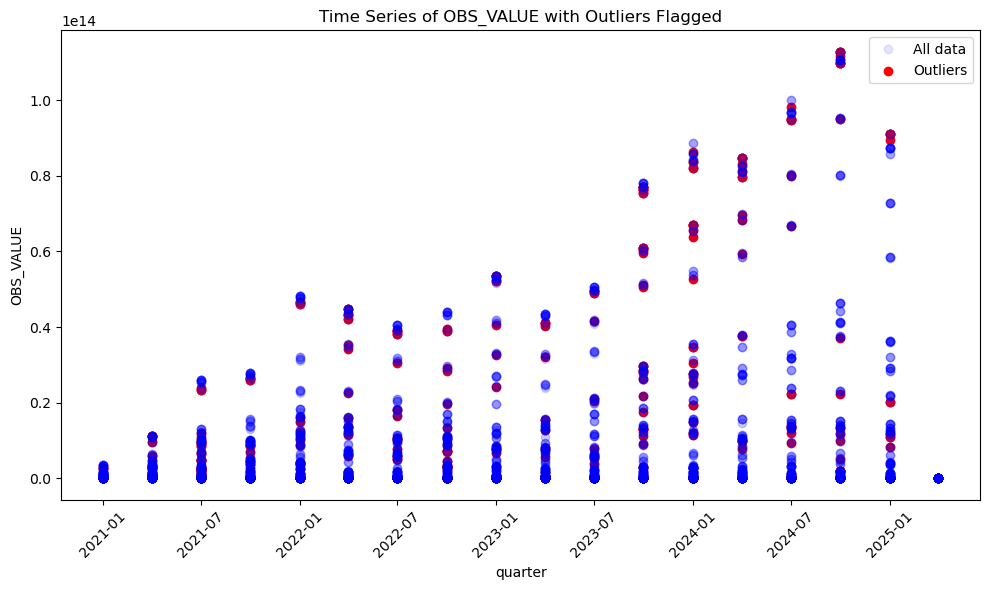

In [9]:
#based on random forest outliers

pdf_out = a.toPandas()
pdf_outliers = pdf_out[pdf_out['rfr_outlier'] == True]
plt.figure(figsize=(10, 6))

plt.plot(
    pdf_out['quarter_date'],
    pdf_out['OBS_VALUE'],
    marker='o',
    linestyle='',
    color='blue',
    alpha=0.1,
    label='All data'
)

plt.scatter(
    pdf_outliers['quarter_date'],
    pdf_outliers['OBS_VALUE'],
    color='red',
    label='Outliers'
)

plt.xlabel('quarter')
plt.ylabel('OBS_VALUE')
plt.title('Time Series of OBS_VALUE with Outliers Flagged')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
a.show(10)

25/04/30 12:34:25 WARN TaskSetManager: Stage 16 contains a task of very large size (5094 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+------------+----------+------------------+----------------+-------------------+-----------+------------+-----------+---+--------------------+-----------+----------+------------+-------------------+--------------+-------------------+-----------+
|                 KEY|               TITLE|TITLE_COMPL|      PROSP3_MEASURE|         FREQ|    S_NCA|PROSP3_SECURITIES_TYPE|MTR|CURR_ISSNC|PROSP3_OFFER_TYPE|PROSP3_DOCUMENT_TYPE|SEC_TYPE_CFI|ISSUER_COU|     ISSUER_SECTOR|PROSP3_PRSP_TYPE|PROSP3_SME_CAT_TYPE|PROSP3_PSSP|PROSP3_VENUE|PROSP3_LNGG| MV|               GROUP|TIME_PERIOD|        PK|   OBS_VALUE|       quarter_date|      pred_rfr|       residual_rfr|rfr_outlier|
+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+----------------

25/04/30 12:34:29 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 16 (TID 87): Attempting to kill Python Worker


### 6. Trying the model with a lag predictor in the feature cols

In [11]:
# 1) parse your quarter into a real date
parse_q = f.expr("""
  to_date(
    concat(
      split(TIME_PERIOD, '-Q')[0],
      '-',
      (cast(split(TIME_PERIOD, '-Q')[1] as int)-1)*3+1,
      '-01'
    )
  )
""")

df2 = df_joined \
  .withColumn('quarter_date', parse_q)

# 2) define a window per country+CFI, ordered by date
w = Window.partitionBy('S_NCA','SEC_TYPE_CFI') \
          .orderBy('quarter_date')

# 3) add one‑quarter lag
df2 = df2.withColumn('lag1_obs', f.lag('OBS_VALUE').over(w))

# 4) add a numeric time feature
df2 = df2.withColumn('time_index',
    f.year('quarter_date')*10 + ((f.quarter('quarter_date')-1))
)

# drop the first row per group (where lag1_obs is null)
df2 = df2.filter(f.col('lag1_obs').isNotNull())

In [12]:
e = melisa_outliers(
    spark_df    = df2,
    mode        = 'random_forest_regressor',
    numbercol   = 'OBS_VALUE',
    groupbycols = ['S_NCA','SEC_TYPE_CFI'],
    showstats   = True,
    min_filter  = 0,
    feature_cols= ['lag1_obs','time_index']
)

25/04/30 12:34:29 WARN TaskSetManager: Stage 18 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
/var/folders/v1/v83gn92x7vv8phs46b_nj2gr0000gn/T/ipykernel_96044/3215581215.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(process_group)


rfr_outlier
False    149525
True       1803
Name: count, dtype: int64


25/04/30 12:35:02 WARN TaskSetManager: Stage 26 contains a task of very large size (5301 KiB). The maximum recommended task size is 1000 KiB.


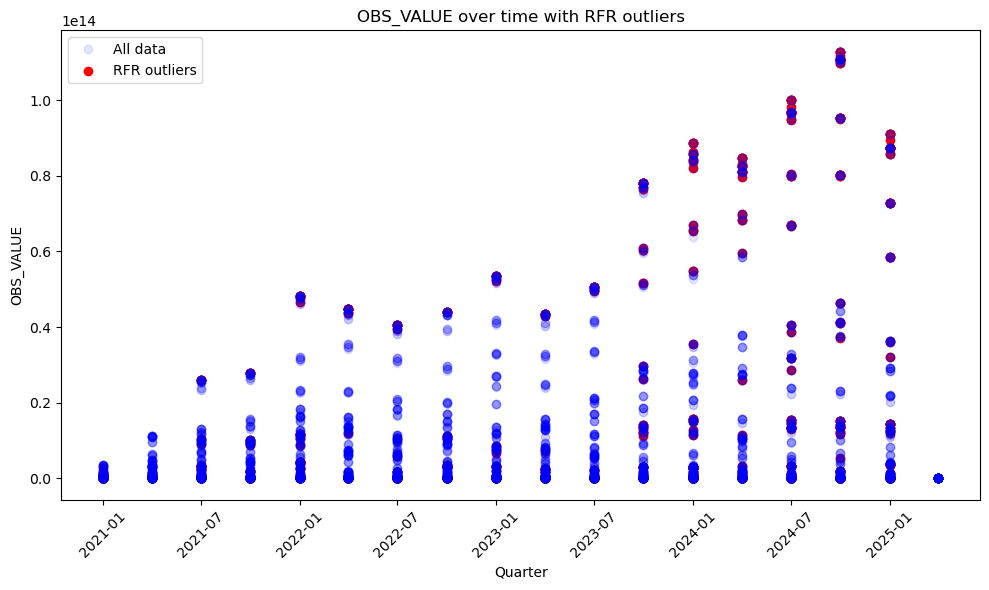

In [13]:
## Graph RF results with a lag.

pdf = e.select('quarter_date','OBS_VALUE','rfr_outlier').toPandas()
pdf_out = pdf  # alias for clarity
pdf_outliers = pdf[pdf['rfr_outlier'] == True]

plt.figure(figsize=(10, 6))

# all data as marker-only points
plt.plot(
    pdf_out['quarter_date'],
    pdf_out['OBS_VALUE'],
    marker='o',
    linestyle='',
    color='blue',
    alpha=0.1,
    label='All data'
)

# outliers overlaid in red
plt.scatter(
    pdf_outliers['quarter_date'],
    pdf_outliers['OBS_VALUE'],
    color='red',
    label='RFR outliers'
)

plt.xlabel('Quarter')
plt.ylabel('OBS_VALUE')
plt.title('OBS_VALUE over time with RFR outliers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
# Select only the columns you need
pdf = (
    e
    .select('KEY','TIME_PERIOD', 'S_NCA', 'SEC_TYPE_CFI',
            'OBS_VALUE','quarter_date', 'rfr_outlier')
    .toPandas()
)

25/04/30 12:35:05 WARN TaskSetManager: Stage 27 contains a task of very large size (5301 KiB). The maximum recommended task size is 1000 KiB.


In [15]:
pdf['S_NCA'].value_counts()

S_NCA
[A6] EEA30             16682
[A1] World             16682
[V5] EU27              16176
[I8] EA19              14422
[LU] Luxembourg         8950
[IE] Ireland            7992
[K0] EU not in EA19     7283
[DE] Germany            6021
[SE] Sweden             5352
[FR] France             4707
[A0] EEA3               3989
[NL] Netherlands        3956
[AT] Austria            3924
[IT] Italy              2800
[NO] Norway             2600
[ES] Spain              2392
[BE] Belgium            2316
[LI] Liechtenstein      2260
[CZ] Czechia            2007
[PL] Poland             1877
[SK] Slovakia           1859
[BG] Bulgaria           1747
[DK] Denmark            1736
[FI] Finland            1643
[IS] Iceland            1495
[MT] Malta              1414
[GR] Greece             1373
[LV] Latvia             1321
[RO] Romania            1261
[PT] Portugal           1246
[HU] Hungary             919
[EE] Estonia             885
[HR] Croatia             746
[LT] Lithuania           666
[SI] Slo

In [16]:
pdf[(pdf['S_NCA'] == '[DE] Germany') & (pdf['rfr_outlier'] == True)].groupby('SEC_TYPE_CFI')['rfr_outlier'].sum().loc[lambda s: s>0]

SEC_TYPE_CFI
Z                                                9
[DE] Structured debt (no capital protection)     6
[DM] Other debt                                  3
[DS] Structured debt (capital protection)        1
[DT] MTN                                         2
[D] Debt                                         2
[ES] Shares                                      3
[EY] Structured instruments (participation)      3
[E] Equity                                       6
[RF] Mini-future certificates                    3
[RW] Warrants                                    3
[R] Entitlement (rights)                        11
[SCRT] Securities                                5
[ZALL] All records if applicable                 5
[ZNAV] CFI not available                         3
Name: rfr_outlier, dtype: int64

In [17]:
sub = pdf[
    (pdf['S_NCA']   == '[DE] Germany') &
    (pdf['SEC_TYPE_CFI'] == '[DM] Other debt')
]

In [18]:
sub

KEY TIME_PERIOD  \
97741  PROSP3.NUM_INSTR.Q.DE.Z.Z.Z.Z.Z.DM.Z.S12.Z.Z.Z...     2021-Q1   
97742  PROSP3.NUM_INSTR.Q.DE.Z.Z.Z.Z.Z.DM.Z.ZALL.Z.Z....     2021-Q1   
97743  PROSP3.NUM_ISSUER.Q.DE.Z.Z.Z.Z.Z.DM.A1_Z.Z.Z.Z...     2021-Q1   
97744  PROSP3.NUM_ISSUER.Q.DE.Z.Z.Z.Z.Z.DM.A6.Z.Z.Z.Z...     2021-Q2   
97745  PROSP3.NUM_ISSUER.Q.DE.Z.Z.Z.Z.Z.DM.DE.Z.Z.Z.Z...     2021-Q2   
...                                                  ...         ...   
97940      PROSP3.MV.Q.DE.Z.Z.Z.Z.Z.DM.Z.S11.Z.Z.Z.Z.Z.Z     2025-Q1   
97941  PROSP3.NUM_INSTR.Q.DE.Z.Z.Z.Z.Z.DM.Z.S12.Z.Z.Z...     2025-Q1   
97942  PROSP3.NUM_ISSUER.Q.DE.Z.Z.Z.Z.Z.DM.A1.Z.Z.Z.Z...     2025-Q1   
97943  PROSP3.NUM_INSTR.Q.DE.Z.Z.Z.Z.Z.DM.Z.S11.Z.Z.Z...     2025-Q1   
97944  PROSP3.NUM_INSTR.Q.DE.Z.Z.Z.Z.Z.DM.Z.ZALL.Z.Z....     2025-Q1   

              S_NCA     SEC_TYPE_CFI   OBS_VALUE quarter_date  rfr_outlier  
97741  [DE] Germany  [DM] Other debt        14.0   2021-01-01        False  
97742  [DE] Germany  [DM] Other debt        14.0   2021-01-01        False  
97743  [DE] Germany  [DM] Other debt         1.0   2021-01-01        False  
97744  [DE] Germany  [DM] Other debt         3.0   2021-04-01        False  
97745  [DE] Germany  [DM] Other debt         3.0   2021-04-01        False  
...             ...              ...         ...          ...          ...  
97940  [DE] Germany  [DM] Other debt  57357036.0   2025-01-01        False  
97941  [DE] Germany  [DM] Other debt        21.0   2025-01-01        False  
97942  [DE] Germany  [DM] Other debt         2.0   2025-01-01        False  
97943  [DE] Germany  [DM] Other debt         8.0   2025-01-01        False  
97944  [DE] Germany  [DM] Other debt        29.0   2025-01-01        False  

[204 rows x 7 columns]

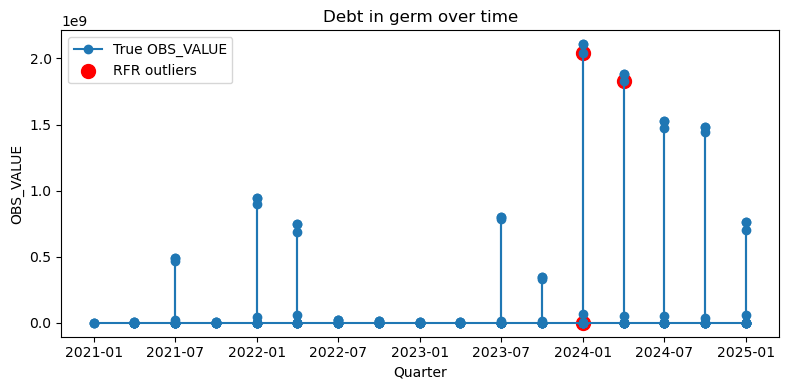

In [19]:
#Plotting outliers for feature specific.

plt.figure(figsize=(8,4))
plt.plot(
    sub['quarter_date'],
    sub['OBS_VALUE'],
    '-o',
    label='True OBS_VALUE'
)

out = sub[sub['rfr_outlier']]
plt.scatter(
    out['quarter_date'],
    out['OBS_VALUE'],
    s=100,
    color='red',
    label='RFR outliers'
)

plt.title("Debt in germ over time")
plt.xlabel("Quarter")
plt.ylabel("OBS_VALUE")
plt.legend()
plt.tight_layout()
plt.show()

### 7. Adding country Mappings

In [20]:
mapping_df = pd.read_excel('Country Mapping.xlsx')


In [21]:
mapping_df

CODE DIRECT_PARENT  LEVEL_PARENT  ORDER  \
0          Z           NaN             0    NaN   
1       ZNAV             Z             1    NaN   
2         A1             Z             1    NaN   
3       A1_Z            A1             2    NaN   
4    A1_TRNS            A1             2    NaN   
..       ...           ...           ...    ...   
292       EH         UN015             5    NaN   
293       YE         UN202             5    NaN   
294       ZM         UN202             5    NaN   
295       ZW         UN202             5    NaN   
296       SZ         UN202             5    NaN   

                       CODE_DESCRIPTION  
0      Filter not applied for location   
1                 Country not available  
2                                 World  
3                  World - Undetermined  
4    World - International organisation  
..                                  ...  
292                      Western Sahara  
293                               Yemen  
294                              Zambia  
295                            Zimbabwe  
296                            Eswatini  

[297 rows x 5 columns]

In [22]:
parent_map = dict(
    zip(
        mapping_df['CODE'],
        mapping_df['DIRECT_PARENT']
    )
)

In [23]:
pdf

KEY TIME_PERIOD  \
0       PROSP3.NUM_INSTR.Q.A0.Z.Z.Z.Z.Z.ED.Z.Z.Z.Z.Z.Z...     2023-Q3   
1       PROSP3.NUM_INSTR.Q.A0.Z.Z.Z.Z.Z.ED.Z.ZNAV.Z.Z....     2023-Q3   
2       PROSP3.NUM_ISSUER.Q.A0.Z.Z.Z.Z.Z.ED.ROW.Z.Z.Z....     2023-Q3   
3             PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.ED.Z.Z.Z.Z.Z.Z.Z.Z     2023-Q3   
4       PROSP3.NUM_ISSUER.Q.A0.Z.Z.Z.Z.Z.ED.UN019.Z.Z....     2023-Q3   
...                                                   ...         ...   
151323  PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.ZALL.ROW.Z.Z....     2025-Q2   
151324  PROSP3.NUM_INSTR.Q.V5.Z.Z.Z.Z.Z.ZALL.Z.Z.Z.Z.Z...     2025-Q2   
151325  PROSP3.NUM_INSTR.Q.V5.Z.Z.Z.Z.Z.ZALL.Z.ZALL.Z....     2025-Q2   
151326  PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.ZALL.A1.Z.Z.Z...     2025-Q2   
151327  PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.ZALL.LU.Z.Z.Z...     2025-Q2   

            S_NCA                      SEC_TYPE_CFI  OBS_VALUE quarter_date  \
0       [A0] EEA3                  [ED] DR equities        1.0   2023-07-01   
1       [A0] EEA3                  [ED] DR equities        1.0   2023-07-01   
2       [A0] EEA3                  [ED] DR equities        1.0   2023-07-01   
3       [A0] EEA3                  [ED] DR equities  1834864.6   2023-07-01   
4       [A0] EEA3                  [ED] DR equities        1.0   2023-07-01   
...           ...                               ...        ...          ...   
151323  [V5] EU27  [ZALL] All records if applicable        1.0   2025-04-01   
151324  [V5] EU27  [ZALL] All records if applicable       24.0   2025-04-01   
151325  [V5] EU27  [ZALL] All records if applicable       24.0   2025-04-01   
151326  [V5] EU27  [ZALL] All records if applicable        4.0   2025-04-01   
151327  [V5] EU27  [ZALL] All records if applicable        1.0   2025-04-01   

        rfr_outlier  
0             False  
1             False  
2             False  
3             False  
4             False  
...             ...  
151323        False  
151324        False  
151325        False  
151326        False  
151327        False  

[151328 rows x 7 columns]

### 8. Flagging up one parent.

In [24]:
# 3) Extract the raw code from S_NCA
pdf['code'] = pdf['S_NCA'].str.extract(r'\[([^\]]+)\]')

# 4) Flagged rows = those your RF already marked
flagged = pdf.loc[
    pdf['rfr_outlier'],
    ['TIME_PERIOD','SEC_TYPE_CFI','code']
].copy()

# 5) Map each code to its *immediate* parent
flagged['ancestor_code'] = flagged['code'].map(parent_map)

# 6) Drop any that didn’t have a parent
flagged_expanded = flagged.dropna(subset=['ancestor_code'])

# 7) Create an inherited-flag on the original pdf
pdf['inherited_outlier'] = False

mask = pd.merge(
    pdf,
    flagged_expanded[['TIME_PERIOD','SEC_TYPE_CFI','ancestor_code']],
    left_on  = ['TIME_PERIOD','SEC_TYPE_CFI','code'],
    right_on = ['TIME_PERIOD','SEC_TYPE_CFI','ancestor_code'],
    how      = 'left',
    indicator = '_hit'
)['_hit'] == 'both'

pdf.loc[mask, 'inherited_outlier'] = True

# 8) Inspect
print(
    pdf[[
        'KEY','TIME_PERIOD','S_NCA','SEC_TYPE_CFI',
        'OBS_VALUE','rfr_outlier','inherited_outlier'
    ]].head(10)
)

                                                 KEY TIME_PERIOD      S_NCA  \
0  PROSP3.NUM_INSTR.Q.A0.Z.Z.Z.Z.Z.ED.Z.Z.Z.Z.Z.Z...     2023-Q3  [A0] EEA3   
1  PROSP3.NUM_INSTR.Q.A0.Z.Z.Z.Z.Z.ED.Z.ZNAV.Z.Z....     2023-Q3  [A0] EEA3   
2  PROSP3.NUM_ISSUER.Q.A0.Z.Z.Z.Z.Z.ED.ROW.Z.Z.Z....     2023-Q3  [A0] EEA3   
3        PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.ED.Z.Z.Z.Z.Z.Z.Z.Z     2023-Q3  [A0] EEA3   
4  PROSP3.NUM_ISSUER.Q.A0.Z.Z.Z.Z.Z.ED.UN019.Z.Z....     2023-Q3  [A0] EEA3   
5     PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.ED.Z.ZNAV.Z.Z.Z.Z.Z.Z     2023-Q3  [A0] EEA3   
6  PROSP3.NUM_ISSUER.Q.A0.Z.Z.Z.Z.Z.ED.A1.Z.Z.Z.Z...     2024-Q1  [A0] EEA3   
7  PROSP3.NUM_INSTR.Q.A0.Z.Z.Z.Z.Z.ED.Z.Z.Z.Z.Z.Z...     2024-Q1  [A0] EEA3   
8  PROSP3.NUM_INSTR.Q.A0.Z.Z.Z.Z.Z.ED.Z.ZNAV.Z.Z....     2024-Q1  [A0] EEA3   
9  PROSP3.NUM_ISSUER.Q.A0.Z.Z.Z.Z.Z.ED.ROW.Z.Z.Z....     2024-Q1  [A0] EEA3   

       SEC_TYPE_CFI  OBS_VALUE  rfr_outlier  inherited_outlier  
0  [ED] DR equities        1.0        False              False  


In [25]:
pdf[pdf['inherited_outlier']==True]

KEY TIME_PERIOD  \
448     PROSP3.NUM_ISSUER.Q.A1.Z.Z.Z.Z.Z.Z.CH.Z.Z.Z.Z....     2021-Q3   
449     PROSP3.NUM_ISSUER.Q.A1.Z.Z.Z.Z.Z.Z.CZ.Z.Z.Z.Z....     2021-Q3   
450     PROSP3.NUM_ISSUER.Q.A1.Z.Z.Z.Z.Z.Z.E2.Z.Z.Z.Z....     2021-Q3   
451     PROSP3.NUM_ISSUER.Q.A1.Z.Z.Z.Z.Z.Z.HR.Z.Z.Z.Z....     2021-Q3   
452     PROSP3.NUM_ISSUER.Q.A1.Z.Z.Z.Z.Z.Z.SE.Z.Z.Z.Z....     2021-Q3   
...                                                   ...         ...   
151191  PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.ZALL.UN019.Z....     2024-Q3   
151192  PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.ZALL.BE.Z.Z.Z...     2024-Q3   
151193  PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.ZALL.GB.Z.Z.Z...     2024-Q3   
151194  PROSP3.NUM_ISSUER.Q.V5.Z.Z.Z.Z.Z.ZALL.ROW.Z.Z....     2024-Q3   
151195  PROSP3.NUM_INSTR.Q.V5.Z.Z.Z.Z.Z.ZALL.Z.S13.Z.Z...     2024-Q3   

             S_NCA                      SEC_TYPE_CFI  OBS_VALUE quarter_date  \
448     [A1] World                                 Z        7.0   2021-07-01   
449     [A1] World                                 Z       21.0   2021-07-01   
450     [A1] World                                 Z       42.0   2021-07-01   
451     [A1] World                                 Z        3.0   2021-07-01   
452     [A1] World                                 Z       92.0   2021-07-01   
...            ...                               ...        ...          ...   
151191   [V5] EU27  [ZALL] All records if applicable       10.0   2024-07-01   
151192   [V5] EU27  [ZALL] All records if applicable       10.0   2024-07-01   
151193   [V5] EU27  [ZALL] All records if applicable       14.0   2024-07-01   
151194   [V5] EU27  [ZALL] All records if applicable       49.0   2024-07-01   
151195   [V5] EU27  [ZALL] All records if applicable      379.0   2024-07-01   

        rfr_outlier code  inherited_outlier  
448           False   A1               True  
449           False   A1               True  
450           False   A1               True  
451           False   A1               True  
452           False   A1               True  
...             ...  ...                ...  
151191        False   V5               True  
151192         True   V5               True  
151193         True   V5               True  
151194        False   V5               True  
151195        False   V5               True  

[60088 rows x 9 columns]

Ask Jordi abt the further granularity data to perform the actual time series analysis.

### 9. RF with further stat features

In [26]:
stats = df2.groupBy('S_NCA','SEC_TYPE_CFI').agg(
    f.expr("percentile_approx(OBS_VALUE, 0.5)").alias("median"),
    f.stddev("OBS_VALUE").alias("stddev")
)

In [27]:
df_thresh = (
  df2
    .join(stats, on=['S_NCA','SEC_TYPE_CFI'], how='left')
    .withColumn(
      'is_outlier_3sd',
      f.abs(f.col('OBS_VALUE') - f.col('median')) > 3 * f.col('stddev')
    )
    .withColumn(
      'is_outlier_4sd',
      f.abs(f.col('OBS_VALUE') - f.col('median')) > 4 * f.col('stddev')
    )
)

In [28]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

In [29]:
from pyspark.sql.types import DoubleType
df2 = df2.withColumn("OBS_VALUE", df2["OBS_VALUE"].cast(DoubleType()))
df2 = df2.withColumn("lag1_obs", df2["lag1_obs"].cast(DoubleType()))

In [30]:
df2.show(10)

25/04/30 12:35:09 WARN TaskSetManager: Stage 29 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+----------------+----------------+--------------------+----------------+-------------------+-----------+------------+-----------+---+--------------------+-----------+---------------+---------+------------+---------+----------+
|                 KEY|               TITLE|TITLE_COMPL|      PROSP3_MEASURE|         FREQ|    S_NCA|PROSP3_SECURITIES_TYPE|MTR|CURR_ISSNC|PROSP3_OFFER_TYPE|PROSP3_DOCUMENT_TYPE|    SEC_TYPE_CFI|      ISSUER_COU|       ISSUER_SECTOR|PROSP3_PRSP_TYPE|PROSP3_SME_CAT_TYPE|PROSP3_PSSP|PROSP3_VENUE|PROSP3_LNGG| MV|               GROUP|TIME_PERIOD|             PK|OBS_VALUE|quarter_date| lag1_obs|time_index|
+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+---------------

In [31]:
assembler = VectorAssembler(
  inputCols=['lag1_obs','time_index'],
  outputCol='features'
)

In [32]:
# it gave an error before, be careful with the version of RANDOM FOREST REGRESSOR
# you import bcs if u use the one from sklearn, it will not work, use the one
# from pyspark.

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="OBS_VALUE",
    predictionCol="prediction",
    numTrees=100
)

# 3) build and fit the pipeline
pipeline = Pipeline(stages=[assembler, rf])
model = pipeline.fit(df2)

# 4) make predictions
predictions = model.transform(df2)
predictions.select("OBS_VALUE", "prediction").show(20)

25/04/30 12:35:10 WARN TaskSetManager: Stage 38 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 12:35:20 WARN TaskSetManager: Stage 81 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+---------+--------------------+
|OBS_VALUE|          prediction|
+---------+--------------------+
|     25.0|8.159148314525026E10|
|      1.0|8.159148314525026E10|
|      1.0|6.863520652445905E10|
|      1.0|6.863520652445905E10|
|      1.0|6.863520652445905E10|
|     24.0|6.863520652445905E10|
|      1.0|8.159148314525026E10|
|      5.0|6.863520652445905E10|
|      3.0|7.612951242397658E10|
|     24.0|6.973539097506702E10|
|      1.0|8.159148314525026E10|
|      1.0|6.863520652445905E10|
|     15.0|6.863520652445905E10|
|      4.0|8.159148314525026E10|
|      3.0|7.321475250046602E10|
|      1.0|6.973539097506702E10|
|      1.0|6.863520652445905E10|
|      1.0|6.863520652445905E10|
|     14.0|6.863520652445905E10|
|      1.0|8.159148314525026E10|
+---------+--------------------+
only showing top 20 rows



In [ ]:
## keep pandas , param , ml package --> different model

In [40]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    VectorAssembler,
    StringIndexer,
    OneHotEncoder
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pyspark.sql.functions as F
from pyspark.sql.types import DoubleType

# 0) Prepare your features + label
df_clf = (
    df2
    # join your stats as before...
    .join(stats, on=['S_NCA','SEC_TYPE_CFI'])
    .withColumn(
        'is_outlier_3sd',
        (F.abs(F.col('OBS_VALUE') - F.col('median')) > 3 * F.col('stddev'))
          .cast(DoubleType())
    )
    .withColumn('lag1_obs', F.coalesce('lag1_obs', F.lit(0.0)))
)

# 1) Categorical indexing + one-hot
si_nca = StringIndexer(inputCol='S_NCA',        outputCol='S_NCA_idx')
si_cfi = StringIndexer(inputCol='SEC_TYPE_CFI', outputCol='CFI_idx')

ohe_nca = OneHotEncoder(inputCol='S_NCA_idx', outputCol='S_NCA_vec')
ohe_cfi = OneHotEncoder(inputCol='CFI_idx',   outputCol='CFI_vec')

# 2) Assemble feature vector
feat_cols = [
    'lag1_obs', 'time_index',
    'median', 'stddev',
    'S_NCA_vec', 'CFI_vec'
]
assembler = VectorAssembler(inputCols=feat_cols, outputCol='features')

# 3) RandomForestClassifier
rf_clf = RandomForestClassifier(
    featuresCol='features',
    labelCol='is_outlier_3sd',
    predictionCol='pred',
    probabilityCol='prob',
    numTrees=100,
    maxDepth=5
)

# 4) Build the pipeline
pipeline = Pipeline(stages=[
    si_nca, si_cfi, ohe_nca, ohe_cfi,
    assembler, rf_clf
])

# 5) Train/test split
train, test = df_clf.randomSplit([0.8,0.2], seed=42)
model       = pipeline.fit(train)
preds       = model.transform(test)

# 6) Evaluate with AUC
evaluator = BinaryClassificationEvaluator(
    labelCol='is_outlier_3sd',
    rawPredictionCol='prob',
    metricName='areaUnderROC'
)
auc = evaluator.evaluate(preds)
print(f"Test AUC = {auc:.3f}")

# 7) Confusion matrix
cm = (
    preds
    .groupBy('is_outlier_3sd', 'pred')
    .count()
    .orderBy('is_outlier_3sd','pred')
)
cm.show()

25/04/30 12:43:19 WARN TaskSetManager: Stage 388 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 12:43:19 WARN TaskSetManager: Stage 390 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 12:43:20 WARN TaskSetManager: Stage 413 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 12:43:21 WARN TaskSetManager: Stage 415 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 12:43:22 WARN TaskSetManager: Stage 438 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 12:43:22 WARN TaskSetManager: Stage 440 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 12:43:23 WARN TaskSetManager: Stage 448 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.

Test AUC = 0.623


25/04/30 12:43:33 WARN TaskSetManager: Stage 612 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+--------------+----+-----+
|is_outlier_3sd|pred|count|
+--------------+----+-----+
|           0.0| 0.0|29164|
|           1.0| 0.0|  959|
+--------------+----+-----+



In [42]:
preds.show(10)

25/04/30 12:45:21 WARN TaskSetManager: Stage 635 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 12:45:22 WARN TaskSetManager: Stage 637 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+----------+----------------+--------------------+--------------------+-----------+--------------------+-------------+----------------------+---+----------+-----------------+--------------------+----------+--------------------+----------------+-------------------+-----------+------------+-----------+---+--------------------+-----------+---------------+-------------+------------+---------+----------+------+--------------------+--------------+---------+-------+---------------+---------------+--------------------+--------------------+--------------------+----+
|     S_NCA|    SEC_TYPE_CFI|                 KEY|               TITLE|TITLE_COMPL|      PROSP3_MEASURE|         FREQ|PROSP3_SECURITIES_TYPE|MTR|CURR_ISSNC|PROSP3_OFFER_TYPE|PROSP3_DOCUMENT_TYPE|ISSUER_COU|       ISSUER_SECTOR|PROSP3_PRSP_TYPE|PROSP3_SME_CAT_TYPE|PROSP3_PSSP|PROSP3_VENUE|PROSP3_LNGG| MV|               GROUP|TIME_PERIOD|             PK|    OBS_VALUE|quarter_date| lag1_obs|time_index|median|              stddev|is_out

I can also make the assign direct parent a function.

25/04/30 12:28:34 WARN TaskSetManager: Stage 625 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 12:28:35 WARN TaskSetManager: Stage 627 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


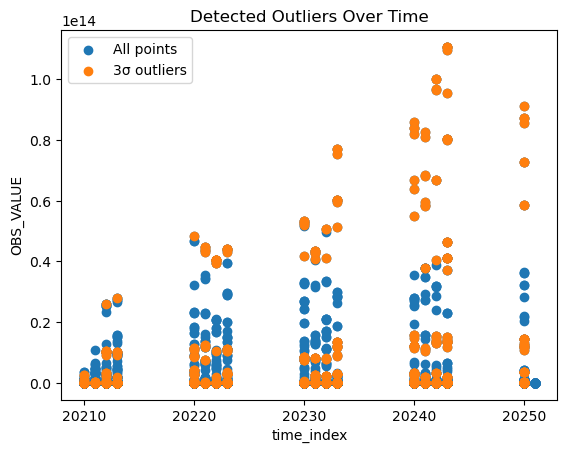

In [47]:
import matplotlib.pyplot as plt

# Convert your Spark predictions to Pandas
pdf = preds.select('time_index', 'OBS_VALUE', 'is_outlier_3sd').toPandas()

# Plot all observations
plt.figure()
plt.scatter(pdf['time_index'], pdf['OBS_VALUE'], label='All points')

# Highlight the outliers
outliers = pdf[pdf['is_outlier_3sd'] == 1.0]
plt.scatter(outliers['time_index'], outliers['OBS_VALUE'], label='3σ outliers')

plt.xlabel('time_index')
plt.ylabel('OBS_VALUE')
plt.title('Detected Outliers Over Time')
plt.legend()
plt.show()

In [38]:
pdf.head(10)

quarter_date     OBS_VALUE  rfr_outlier       S_NCA      SEC_TYPE_CFI  \
0   2023-07-01  1.834865e+06        False   [A0] EEA3  [ED] DR equities   
1   2023-07-01  1.000000e+00        False   [A0] EEA3  [ED] DR equities   
2   2024-01-01  1.000000e+00        False   [A0] EEA3  [ED] DR equities   
3   2021-01-01  3.500794e+12        False  [A1] World                 Z   
4   2022-07-01  4.048987e+13        False  [A1] World                 Z   
5   2023-07-01  5.067352e+13        False  [A1] World                 Z   
6   2025-01-01  9.110055e+13        False  [A1] World                 Z   
7   2022-01-01  1.856984e+06        False  [A1] World                 Z   
8   2024-07-01  2.037958e+06        False  [A1] World                 Z   
9   2024-10-01  1.988228e+06        False  [A1] World                 Z   

   Status  
0  Normal  
1  Normal  
2  Normal  
3  Normal  
4  Normal  
5  Normal  
6  Normal  
7  Normal  
8  Normal  
9  Normal

In [43]:
import pandas as pd
import plotly.express as px

# 1) Convert your Spark predictions to pandas
pdf = preds.select(
    'quarter_date', 'OBS_VALUE', 'is_outlier_3sd', 'S_NCA', 'SEC_TYPE_CFI'
).toPandas()

# 2) Prepare the data
pdf['quarter_date'] = pd.to_datetime(pdf['quarter_date'])
pdf['Status'] = pdf['is_outlier_3sd'].map({0.0: 'Normal', 1.0: '3σ Outlier'})

# 3) Create the interactive scatter
fig = px.scatter(
    pdf,
    x='quarter_date',
    y='OBS_VALUE',
    color='Status',
    color_discrete_map={'Normal': 'blue', '3σ Outlier': 'red'},
    hover_data=['OBS_VALUE', 'S_NCA', 'SEC_TYPE_CFI'],
    title='OBS_VALUE Time Series with 3σ Outliers Highlighted',
    opacity=0.7
)

fig.update_layout(
    xaxis_title='Quarter',
    yaxis_title='OBS_VALUE',
    legend_title='Point Type'
)

fig.show()

25/04/30 13:56:35 WARN TaskSetManager: Stage 652 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.
25/04/30 13:56:35 WARN TaskSetManager: Stage 654 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
preds = model.transform(df2) \
  .withColumn('residual', f.col('OBS_VALUE') - f.col('prediction'))

In [ ]:
res_stats = preds.groupBy('S_NCA','SEC_TYPE_CFI') \
  .agg(f.stddev('residual').alias('res_sd'))

df_rfr = (
  preds
    .join(res_stats, on=['S_NCA','SEC_TYPE_CFI'], how='left')
    .withColumn(
      'is_outlier_rfr',
      f.abs(f.col('residual')) > 4 * f.col('res_sd')


    )
)

In [ ]:
preds.show(10)

25/04/27 21:20:59 WARN TaskSetManager: Stage 120 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+--------------------+-----------+--------------------+-------------+---------+----------------------+---+----------+-----------------+--------------------+----------------+----------------+--------------------+----------------+-------------------+-----------+------------+-----------+---+--------------------+-----------+---------------+---------+------------+---------+----------+-------------------+--------------------+--------------------+
|                 KEY|               TITLE|TITLE_COMPL|      PROSP3_MEASURE|         FREQ|    S_NCA|PROSP3_SECURITIES_TYPE|MTR|CURR_ISSNC|PROSP3_OFFER_TYPE|PROSP3_DOCUMENT_TYPE|    SEC_TYPE_CFI|      ISSUER_COU|       ISSUER_SECTOR|PROSP3_PRSP_TYPE|PROSP3_SME_CAT_TYPE|PROSP3_PSSP|PROSP3_VENUE|PROSP3_LNGG| MV|               GROUP|TIME_PERIOD|             PK|OBS_VALUE|quarter_date| lag1_obs|time_index|           features|          prediction|            residual|
+--------------------+--------------------+-----------+-------------

In [ ]:
print("=== σ-Threshold Outliers (3σ) ===")
df_thresh \
  .filter(f.col('is_outlier_3sd')) \
  .select('KEY','TIME_PERIOD','S_NCA','SEC_TYPE_CFI','OBS_VALUE','is_outlier_3sd') \
  .show(truncate=False)

print("=== σ-Threshold Outliers (4σ) ===")
df_thresh \
  .filter(f.col('is_outlier_4sd')) \
  .select('KEY','TIME_PERIOD','S_NCA','SEC_TYPE_CFI','OBS_VALUE','is_outlier_4sd') \
  .show(truncate=False)

# 2) Show the Random-Forest outliers
print("=== Random Forest Residual Outliers (>4σ) ===")
df_rfr \
  .filter(f.col('is_outlier_rfr')) \
  .select('KEY','TIME_PERIOD','S_NCA','SEC_TYPE_CFI','OBS_VALUE','prediction','residual','is_outlier_rfr') \
  .show(truncate=False)

=== σ-Threshold Outliers (3σ) ===


25/04/27 21:23:07 WARN TaskSetManager: Stage 129 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+---------------------------------------------+-----------+---------+------------------+-------------+--------------+
|KEY                                          |TIME_PERIOD|S_NCA    |SEC_TYPE_CFI      |OBS_VALUE    |is_outlier_3sd|
+---------------------------------------------+-----------+---------+------------------+-------------+--------------+
|PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z   |2021-Q1    |[A0] EEA3|Z                 |9.1921951E9  |true          |
|PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z   |2021-Q2    |[A0] EEA3|Z                 |7.4265344E9  |true          |
|PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z   |2021-Q3    |[A0] EEA3|Z                 |4.4972273E9  |true          |
|PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z   |2021-Q4    |[A0] EEA3|Z                 |4.25556966E9 |true          |
|PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z   |2022-Q1    |[A0] EEA3|Z                 |9.8088991E9  |true          |
|PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z   |2022-Q2  

25/04/27 21:23:25 WARN TaskSetManager: Stage 140 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+----------------------------------------------+-----------+----------+-------------------------------------------+-------------+--------------+
|KEY                                           |TIME_PERIOD|S_NCA     |SEC_TYPE_CFI                               |OBS_VALUE    |is_outlier_4sd|
+----------------------------------------------+-----------+----------+-------------------------------------------+-------------+--------------+
|PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z    |2021-Q1    |[A0] EEA3 |Z                                          |9.1921951E9  |true          |
|PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z    |2021-Q2    |[A0] EEA3 |Z                                          |7.4265344E9  |true          |
|PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z    |2021-Q3    |[A0] EEA3 |Z                                          |4.4972273E9  |true          |
|PROSP3.MV.Q.A0.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z.Z    |2021-Q4    |[A0] EEA3 |Z                                          |4.25556966E9 |t

25/04/27 21:23:33 WARN TaskSetManager: Stage 151 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


+-------------------------------------------------------+-----------+---------+-------------------------------------------+---------+---------------------+----------------------+--------------+
|KEY                                                    |TIME_PERIOD|S_NCA    |SEC_TYPE_CFI                               |OBS_VALUE|prediction           |residual              |is_outlier_rfr|
+-------------------------------------------------------+-----------+---------+-------------------------------------------+---------+---------------------+----------------------+--------------+
|PROSP3.NUM_ISSUER.Q.A0.Z.Z.Z.Z.Z.Z.UN142.Z.Z.Z.Z.Z.Z.Z |2022-Q1    |[A0] EEA3|Z                                          |1.0      |8.957772655915463E11 |-8.957772655905463E11 |true          |
|PROSP3.NUM_PRSP.Q.A0.EQTY.Z.Z.Z.Z.Z.NO.Z.Z.Z.Z.Z.Z.Z   |2022-Q3    |[A0] EEA3|Z                                          |5.0      |8.806961230969921E11 |-8.806961230919921E11 |true          |
|PROSP3.NUM_PRSP.Q.A0.EQTY.Z.Z

25/04/27 21:23:47 WARN TaskSetManager: Stage 162 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


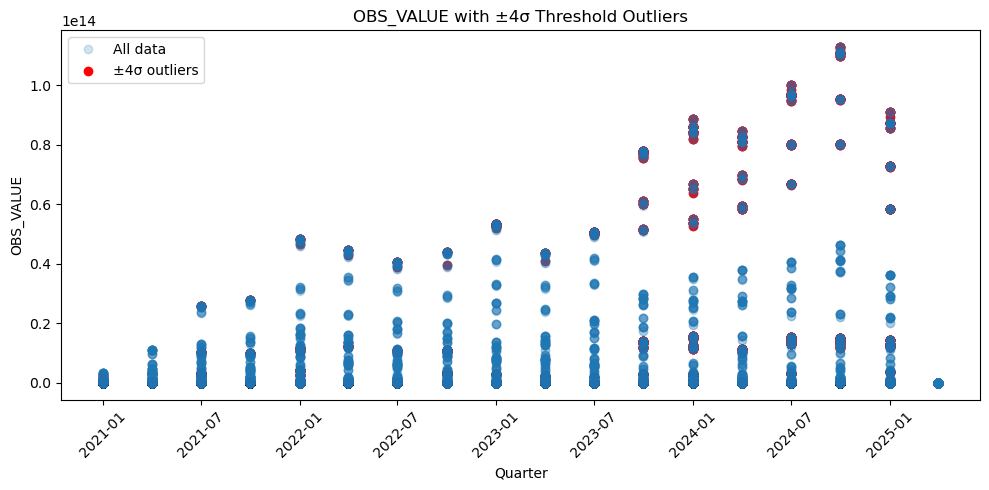

25/04/27 21:24:08 WARN TaskSetManager: Stage 176 contains a task of very large size (1029 KiB). The maximum recommended task size is 1000 KiB.


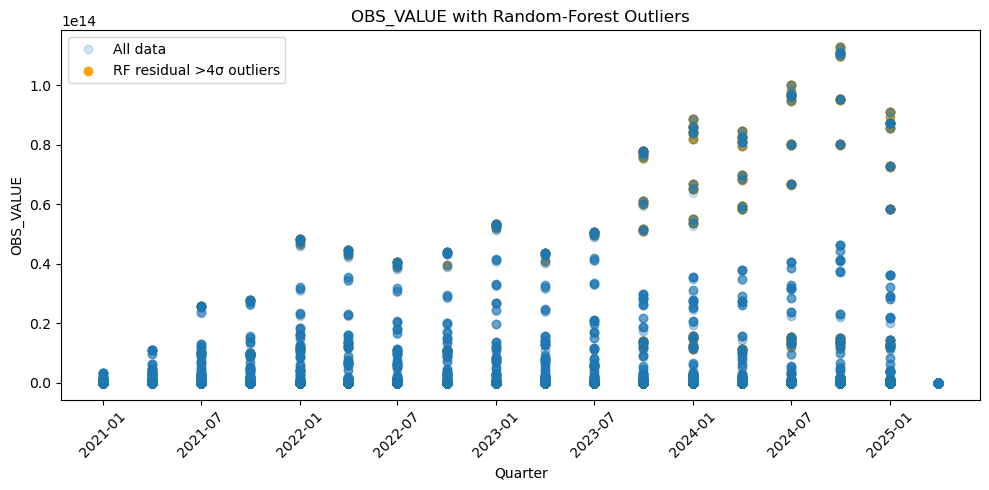

In [ ]:
# --- 1) σ-Threshold (4σ) Outliers ---

# pull into Pandas
pdf_thresh = df_thresh \
    .select('quarter_date','OBS_VALUE','is_outlier_4sd') \
    .toPandas()

# split
all_data   = pdf_thresh
outliers4σ = pdf_thresh[pdf_thresh['is_outlier_4sd']]

plt.figure(figsize=(10,5))
plt.plot(all_data['quarter_date'], all_data['OBS_VALUE'],
         marker='o', linestyle='', alpha=0.2, label='All data')
plt.scatter(outliers4σ['quarter_date'], outliers4σ['OBS_VALUE'],
            color='red', label='±4σ outliers')
plt.xlabel('Quarter')
plt.ylabel('OBS_VALUE')
plt.title('OBS_VALUE with ±4σ Threshold Outliers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- 2) Random-Forest Residual (>4σ) Outliers ---

# pull into Pandas
pdf_rfr = df_rfr \
    .select('quarter_date','OBS_VALUE','is_outlier_rfr') \
    .toPandas()

all_data_rfr   = pdf_rfr
rfr_outliers   = pdf_rfr[pdf_rfr['is_outlier_rfr']]

plt.figure(figsize=(10,5))
plt.plot(all_data_rfr['quarter_date'], all_data_rfr['OBS_VALUE'],
         marker='o', linestyle='', alpha=0.2, label='All data')
plt.scatter(rfr_outliers['quarter_date'], rfr_outliers['OBS_VALUE'],
            color='orange', label='RF residual >4σ outliers')
plt.xlabel('Quarter')
plt.ylabel('OBS_VALUE')
plt.title('OBS_VALUE with Random-Forest Outliers')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 10. Trying with the different outlay of data:

In [ ]:
import pandas as pd
cs1 = pd.read_csv('exp/export.csv')
cs2 = pd.read_csv('exp/export(1).csv')
cs3 = pd.read_csv('exp/export(2).csv')
cs4 = pd.read_csv('exp/export(3).csv')
cs5 = pd.read_csv('exp/export(4).csv')

comp = pd.concat([cs1, cs2, cs3, cs4, cs5], axis=0)
comp.head(10)

Prospectus Type                                      Document Type  \
0        Base Prospectus  Final terms, including the  summary of the ind...   
1        Base Prospectus  Final terms, including the  summary of the ind...   
2        Base Prospectus  Final terms, including the  summary of the ind...   
3        Base Prospectus  Final terms, including the  summary of the ind...   
4        Base Prospectus  Final terms, including the  summary of the ind...   
5        Base Prospectus  Final terms, including the  summary of the ind...   
6        Base Prospectus  Final terms, including the  summary of the ind...   
7        Base Prospectus  Final terms, including the  summary of the ind...   
8  Standalone Prospectus                              Standalone prospectus   
9  Standalone Prospectus                              Standalone prospectus   

  Last Passporting Date Approval or filing date Home Member State  \
0                   NaN              24/05/2025           CZECHIA   
1                   NaN              24/04/2025           CZECHIA   
2                   NaN              24/04/2025           CZECHIA   
3                   NaN              24/04/2025           CZECHIA   
4                   NaN              24/04/2025           CZECHIA   
5                   NaN              24/04/2025           CZECHIA   
6                   NaN              24/04/2025           CZECHIA   
7                   NaN              24/04/2025           CZECHIA   
8                   NaN              22/04/2025           CZECHIA   
9                   NaN              22/04/2025           CZECHIA   

                     Securities Type          ISIN First Passporting Date  \
0  Debt with denomination < €100.000  CZ0003572414                    NaN   
1  Debt with denomination < €100.000  CZ0003572273                    NaN   
2  Debt with denomination < €100.000  CZ0003572422                    NaN   
3  Debt with denomination < €100.000  CZ0003572406                    NaN   
4  Debt with denomination < €100.000  CZ0003572042                    NaN   
5  Debt with denomination < €100.000  CZ0003572059                    NaN   
6  Debt with denomination < €100.000  CZ0003572075                    NaN   
7  Debt with denomination < €100.000  CZ0003572067                    NaN   
8                             Shares  CZ0009013272                    NaN   
9                             Shares  CZ1008000831                    NaN   

  Last Update Date National Document ID        Consideration offered  \
0       26/04/2025           FTWS664847                Max 340000000   
1       25/04/2025           FTWS663992                Max 100000000   
2       26/04/2025           FTWS664848                Max 200000000   
3       26/04/2025           FTWS664849                Max 200000000   
4       26/04/2025           FTWS664853                 Max 50000000   
5       26/04/2025           FTWS665000                Max 150000000   
6       26/04/2025           FTWS665001                  Max 1000000   
7       26/04/2025           FTWS664999                Max 100000000   
8       24/04/2025           STDA100844  From 160140000 to 266900000   
9       24/04/2025           STDA100844  From 120000000 to 600000000   

                                Issuer(s) Name / LEI Host Member State(s)  
0  Českomoravská Projektová VII a.s. - 31570006FB...                  NaN  
1           WOOD SEEDS s.r.o. - 3157004CFGD745LKYZ81                  NaN  
2  Českomoravská Projektová VII a.s. - 31570006FB...                  NaN  
3  Českomoravská Projektová VII a.s. - 31570006FB...                  NaN  
4    BICZ Bond 2024 CR s.r.o. - 3157006C8O37QWMV6H25                  NaN  
5    BICZ Bond 2024 CR s.r.o. - 3157006C8O37QWMV6H25                  NaN  
6    BICZ Bond 2024 CR s.r.o. - 3157006C8O37QWMV6H25                  NaN  
7    BICZ Bond 2024 CR s.r.o. - 3157006C8O37QWMV6H25                  NaN  
8      ALEMAR Food Group a.s. - 315700L63KOVVLIKGM26  

25/04/30 18:54:31 WARN TransportChannelHandler: Exception in connection from /10.60.174.145:54114
java.io.IOException: Operation timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:330)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:284)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:259)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:417)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOptim

#### I can make a function that is like convert to conventional format. And then I can apply Melisa outliers to that.

### 10. Unres

In [ ]:
pdf['quarter_date'].max()

Timestamp('2025-04-01 00:00:00')

In [ ]:
train_start = pdf['quarter_date'].min()
train_end = '2024-09-01'
test_start = '2024-09-01'
test_end = pdf['quarter_date'].max()

df = pdf

df['quarter_date'] = pd.to_datetime(df['quarter_date'])

forecaster = ForecasterRecursive(
    regressor = DecisionTreeRegressor(random_state=123),
    lags      = 30
)

mask       = (df['quarter_date'] >= train_start) & (df['quarter_date'] <= train_end)
y_train    = df.loc[mask, 'OBS_VALUE']
forecaster.fit(y = y_train)

mask_test  = (df['quarter_date'] >= test_start) & (df['quarter_date'] <= test_end)
n_steps    = mask_test.sum()
predictions = forecaster.predict(steps = n_steps)


╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has an unsupported index type (not pandas DatetimeIndex or RangeIndex). The   │
│ index will be replaced by a RangeIndex starting from 0 with a step of 1. To avoid    │
│ this warning, ensure that `y.index` is a DatetimeIndex with a frequency or a         │
│ RangeIndex.                                                                          │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /opt/anaconda3/envs/datasci/lib/python3.12/site-packages/skforecast/utils/utils.py:1 │
│ 411                                                                                  │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `last_window` has an unsupported index type (not pandas DatetimeIndex or             │
│ RangeIndex). The index will be replaced by a RangeIndex starting from 0 with a step  │
│ of 1. To avoid this warning, ensure that `last_window.index` is a DatetimeIndex with │
│ a frequency or a RangeIndex.                                                         │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ /opt/anaconda3/envs/datasci/lib/python3.12/site-packages/skforecast/utils/utils.py:1 │
│ 468                                                                                  │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
train_mask = (df['quarter_date'] >= train_start) & (df['quarter_date'] <= train_end)
y_train    = df.loc[train_mask, 'OBS_VALUE']
arima = pm.AutoARIMA(seasonal=False)
arima.fit(y_train)
test_mask  = (df['quarter_date'] >= test_start) & (df['quarter_date'] <= test_end)
n_test     = test_mask.sum()
arima_train = arima.predict_in_sample()
#arima_test  = arima.predict(n_periods=n_test)

/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/datasci/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_

TypeError: n_periods must be an int

25/04/21 23:48:55 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 281900 ms exceeds timeout 120000 ms
25/04/21 23:48:55 WARN SparkContext: Killing executors is not supported by current scheduler.
25/04/21 23:48:56 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
df.loc[test_start:test_end].plot(ax=ax, label = "Test")
predicted_test.plot(ax=ax, label = 'Predicted DT')
arima_test.plot(ax=ax, label = 'Predicted ARIMA')
ax.legend()